In [1]:
import ckanapi
from pprint import pprint
import geopandas as gpd
import shapely
from shapely.geometry import box, LineString, Point,MultiPoint
from shapely.ops import nearest_points
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import networkx as nx
import re
import itertools
#from geopy import distance
from shapely import wkt
from math import radians, degrees, sin, cos, asin, acos, sqrt, floor
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
site = "https://data.wprdc.org"

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
cwd = os.getcwd() 
#cwd = '/Users/lindsaygraff/Documents/Multimodal Transit Research/Code'

Source: https://data.wprdc.org/dataset/allegheny-county-crash-data/resource/6c8d19a1-e01d-4010-a0cb-a7b31a59eeb7

In [3]:
def get_resource_data(site,resource_id,count=50):
    # Use the datastore_search API endpoint to get <count> records from
    # a CKAN resource.
    ckan = ckanapi.RemoteCKAN(site)
    response = ckan.action.datastore_search(id=resource_id, limit=count)

    # A typical response is a dictionary like this
    #{u'_links': {u'next': u'/api/action/datastore_search?offset=3',
    #             u'start': u'/api/action/datastore_search'},
    # u'fields': [{u'id': u'_id', u'type': u'int4'},
    #             {u'id': u'pin', u'type': u'text'},
    #             {u'id': u'number', u'type': u'int4'},
    #             {u'id': u'total_amount', u'type': u'float8'}],
    # u'limit': 3,
    # u'records': [{u'_id': 1,
    #               u'number': 11,
    #               u'pin': u'0001B00010000000',
    #               u'total_amount': 13585.47},
    #              {u'_id': 2,
    #               u'number': 2,
    #               u'pin': u'0001C00058000000',
    #               u'total_amount': 7827.64},
    #              {u'_id': 3,
    #               u'number': 1,
    #               u'pin': u'0001C01661006700',
    #               u'total_amount': 3233.59}],
    # u'resource_id': u'd1e80180-5b2e-4dab-8ec3-be621628649e',
    # u'total': 88232}
    data = response['records']
    return data

In [4]:
def edgedf_to_gdf(df_edge, df_node, from_node_colname, to_node_colname, nodeid_colname):
    temp = df_edge.merge(df_node, how='left', left_on = from_node_colname, right_on = nodeid_colname)[[from_node_colname, to_node_colname,'x','y']]
    temp = temp.merge(df_node, how='left', left_on = to_node_colname, right_on = nodeid_colname, suffixes = ['_source', '_target'])
    temp.head()
    temp['source_geom'] = gpd.points_from_xy(temp.x_source, temp.y_source, crs="EPSG:4326")
    temp['target_geom'] = gpd.points_from_xy(temp.x_target, temp.y_target, crs="EPSG:4326")
    temp['geometry'] = temp.apply(lambda row: LineString([row['source_geom'], row['target_geom']]), axis=1)
    gdf_edge = gpd.GeoDataFrame(data=temp, crs='EPSG:4326')[[from_node_colname,to_node_colname,'geometry']]    
    return gdf_edge

In [5]:
# convert lat and long in deg-min-sec to decimal degrees
def dms2dd(angle):
    #s = "40 27:10.501"
    dec, ms = tuple(angle.split(' '))
    m, s = tuple(ms.split(':'))
    dd = float(dec) + float(m)/60 + float(s)/3600
    return dd

## Import Study Area

In [6]:
new_dir = cwd.replace('Code', 'Data/PGH_neighborhoods/')
os.chdir(new_dir)
pgh_study_area = pd.read_pickle('pgh_study_area.csv')
pgh_study_area.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
new_dir

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data/PGH_neighborhoods/'

## Pittsburgh Base Road Network Data

The road network data was obtained from Open Street Maps using the python package osmnx. This data was processed in the Build_Street_Network.ipynb file. The oxmnx package allows users to download the Open Street Maps network data in the form of a networkx graph. Users may select the unimodal network of interest, where options include ... For the study, the networks "auto" and "bike" were selected. Once the networkx graph for each of the two unimodal networks was obtained in the Build_Street_Netework.ipynb file, the graph data structure was converted into a nodes csv file and and edges csv file an subsequently stored. These files will be read into this notebook and then converted back to the nx graph structure.

In [8]:
# Read files
# Import driving and biking networks
# G_drive, df_drive_nodes, df_drive_edges = osm_csvs_to_nx('osm_drive_nodes.csv', 'osm_drive_edges.csv')
# G_bike, df_bike_nodes, df_bike_edges = osm_csvs_to_nx('osm_bike_nodes.csv', 'osm_bike_edges.csv')

new_dir = cwd.replace('Code', 'Data/OSM_Data/')
os.chdir(new_dir)

df_drive_edges = pd.read_csv('osm_drive_edges.csv')
df_drive_nodes = pd.read_csv('osm_drive_nodes.csv')
df_bike_edges = pd.read_csv('osm_bike_edges.csv')
df_bike_nodes = pd.read_csv('osm_bike_nodes.csv')
df_drive_nodes.head()

# Convert to gdf so we can clip to the study area
gdf_drive_nodes = gpd.GeoDataFrame(data=df_drive_nodes, geometry=gpd.points_from_xy(df_drive_nodes.x, df_drive_nodes.y, crs="EPSG:4326"))
gdf_bike_nodes = gpd.GeoDataFrame(data=df_bike_nodes, geometry=gpd.points_from_xy(df_bike_nodes.x, df_bike_nodes.y, crs="EPSG:4326"))
gdf_bike_edges = edgedf_to_gdf(df_bike_edges, df_bike_nodes, 'source', 'target', 'nodeID')
gdf_drive_edges = edgedf_to_gdf(df_drive_edges, df_drive_nodes, 'source', 'target', 'nodeID')
gdf_bike_edges.head()

,nodeID,y,x,street_count,highway,ref
0,104198857,40.428221,-79.949252,3,NaN,NaN
1,104212938,40.428105,-79.934502,3,NaN,NaN
2,104250917,40.432987,-79.930534,4,NaN,NaN
3,104250922,40.432767,-79.930550,1,NaN,NaN
4,104250998,40.432270,-79.930502,4,NaN,NaN


,source,target,geometry
0,104194342,104485848,"LINESTRING (-79.92955 40.41436, -79.93012 40.4..."
1,104194342,1768974300,"LINESTRING (-79.92955 40.41436, -79.92833 40.4..."
2,104194342,104194402,"LINESTRING (-79.92955 40.41436, -79.93248 40.4..."
3,104194402,104194450,"LINESTRING (-79.93248 40.41692, -79.93288 40.4..."
4,104194402,104194342,"LINESTRING (-79.93248 40.41692, -79.92955 40.4..."


## Crash Data: vehicle, bicycle, pedestrian

In [9]:
# Get data from 2 most recent years
crash_data_2020 = get_resource_data(site,resource_id="514ae074-f42e-4bfb-8869-8d8c461dd824",count=999999999) 
crash_data_2019 = get_resource_data(site,resource_id="cb0a4d8b-2893-4d20-ad1c-47d5fdb7e8d5",count=999999999) 

In [10]:
# Convert to pandas df and concatenate
df_crash_2020 = pd.DataFrame(crash_data_2020)
df_crash_2019 = pd.DataFrame(crash_data_2019)
#list(df_crash_2020.columns)
cols_keep = ['DEC_LAT', 'DEC_LONG', 'BICYCLE', 'BICYCLE_COUNT', 'PEDESTRIAN', 'PED_COUNT', 
             'SPEED_LIMIT', 'VEHICLE_COUNT', 'TOT_INJ_COUNT']
df_crash_2020 = df_crash_2020[cols_keep]
df_crash_2019 = df_crash_2019[cols_keep]
df_crash = pd.concat([df_crash_2019, df_crash_2020], ignore_index=True)
# Remove rows that do not have both a lat and long populated
df_crash = df_crash.loc[~((df_crash['DEC_LAT'].isnull()) | (df_crash['DEC_LONG'].isnull()))]
# Convert deg-min-sec to decimal degrees
gdf_crash = gpd.GeoDataFrame(df_crash, geometry=gpd.points_from_xy(x=df_crash['DEC_LONG'], y=df_crash['DEC_LAT']), 
                             crs='EPSG:4326')
gdf_crash.head()
# Clip to neighborhood mask
gdf_crash_clip = gpd.clip(gdf_crash, pgh_study_area)
gdf_crash_clip.shape

,DEC_LAT,DEC_LONG,BICYCLE,BICYCLE_COUNT,PEDESTRIAN,PED_COUNT,SPEED_LIMIT,VEHICLE_COUNT,TOT_INJ_COUNT,geometry
0,40.4529,-79.9207,0,0,0,0,25.0,3,2,POINT (-79.92070 40.45290)
1,40.3841,-79.9893,0,0,0,0,25.0,1,1,POINT (-79.98930 40.38410)
2,40.4541,-79.8908,0,0,0,0,25.0,2,1,POINT (-79.89080 40.45410)
3,40.4493,-79.9991,0,0,0,0,25.0,1,0,POINT (-79.99910 40.44930)
4,40.4143,-79.9930,0,0,0,0,30.0,2,0,POINT (-79.99300 40.41430)


(834, 10)

In [11]:
# Separate crashes by bike, pedestrian, vehicle
gdf_ped_crash = gdf_crash_clip.loc[gdf_crash_clip.PEDESTRIAN == 1]  # pedestrian crashes
gdf_ped_crash.shape
gdf_bike_crash = gdf_crash_clip.loc[gdf_crash_clip.BICYCLE == 1]  # bicycle crashes
gdf_bike_crash.shape
gdf_veh_crash = gdf_crash_clip.loc[gdf_crash_clip.VEHICLE_COUNT > 1]  # vehicle crashes
gdf_veh_crash.shape

(29, 10)

(6, 10)

(583, 10)

In [12]:
def flatten_proj(gdfs, crs):
    for g in gdfs:
        g.to_crs(crs=crs, inplace=True)

In [13]:
def join_crash_to_edge(crash_gdf, edge_gdf):
    gdf_crash_edges = crash_gdf.sjoin_nearest(edge_gdf, how='inner', distance_col = 'Distance')
    crash_grouped = gdf_crash_edges.groupby(['source','target']).agg({
        'TOT_INJ_COUNT':['sum','count']}).reset_index() #.sort_values(by='TOT_INJ_COUNT')
    crash_grouped.columns = ['source','target','tot_inj_sum', 'crash_count']
    return crash_grouped

In [14]:
# Spatially join crashes to edges for the bike network and the drive network
# But first flatten the projection
flatten_proj([gdf_bike_crash, gdf_veh_crash, gdf_bike_edges, gdf_drive_edges], 3857)

gdf_crash_edges_bike = join_crash_to_edge(gdf_bike_crash, gdf_bike_edges)
gdf_crash_edges_veh = join_crash_to_edge(gdf_veh_crash, gdf_drive_edges)

#gdf_bike_crash_edges.sort_values(by='Distance')

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
gdf_crash_edges_bike.shape
gdf_crash_edges_veh.sort_values(by='crash_count', ascending=False, inplace=True)

(11, 4)

Now we have the (approximate) count of crashes and the number of injuries for each edge in both the driving network and the biking network

In [16]:
gdf_crash_edges_veh.head()
gdf_crash_edges_bike.head()
new_dir = cwd.replace('Code', 'Data/')
os.chdir(new_dir)
gdf_crash_edges_veh.to_csv('crash_edge_vehicle.csv', index=False)
gdf_crash_edges_bike.to_csv('crash_edge_bike.csv', index=False)

,source,target,tot_inj_sum,crash_count
288,686516268,5320857562,18,24
172,105097756,104618312,16,21
293,988411642,988411624,15,21
292,988411624,988411642,19,21
60,104680982,104681021,10,17


,source,target,tot_inj_sum,crash_count
0,104687150,105797243,1,1
1,104698175,2791788715,1,1
2,104857516,105797446,1,1
3,104905283,9890939663,1,1
4,105013433,302964641,1,1


(array([291.,  26.,   9.,   8.,   5.,   0.,   2.,   0.,   3.,   1.]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'vehicle crash count')

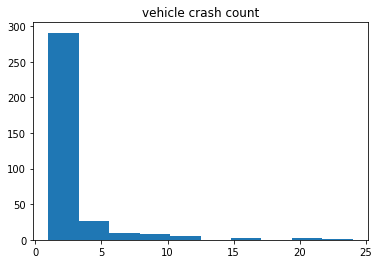

In [17]:
plt.hist(gdf_crash_edges_veh['crash_count'])
plt.title('vehicle crash count')

## Bike Lane Data

In [18]:
new_dir = cwd.replace('Code', 'Data/bike-map-2019')
os.chdir(new_dir)

In [19]:
bikeway_type = ['Bike Lanes', 'On Street Bike Route', 'Protected Bike Lane']
gdf_bikeway = gpd.GeoDataFrame()
for b in bikeway_type:
    new_dir = cwd.replace('Code', 'Data/bike-map-2019/' + b + '/')
    os.chdir(new_dir)
    filename = b + '.shp'
    gdf =  gpd.read_file(filename)
    gdf.to_crs(crs = 4326, inplace=True)
    gdf['bikeway_type'] = b
    cols_keep = ['geometry','bikeway_type']
    gdf = gdf[cols_keep]
    gdf_bikeway = pd.concat([gdf_bikeway, gdf])
gdf_bikeway['bikeway_type'].unique()
gdf_bikeway = gpd.clip(gdf_bikeway, pgh_study_area)
gdf_bikeway.head()

array(['Bike Lanes', 'On Street Bike Route', 'Protected Bike Lane'],
      dtype=object)

,geometry,bikeway_type
186,"LINESTRING (-79.92250 40.41399, -79.92221 40.4...",On Street Bike Route
88,"LINESTRING (-79.92922 40.41975, -79.92715 40.4...",On Street Bike Route
95,"LINESTRING (-79.92120 40.42917, -79.92204 40.4...",On Street Bike Route
89,"LINESTRING (-79.92295 40.43373, -79.92323 40.4...",On Street Bike Route
96,"LINESTRING (-79.92349 40.42974, -79.92120 40.4...",On Street Bike Route


<AxesSubplot:>

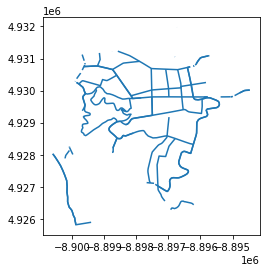

In [20]:
flatten_proj([gdf_bikeway, gdf_bike_nodes], 3857)
gdf_bikeway.plot()

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

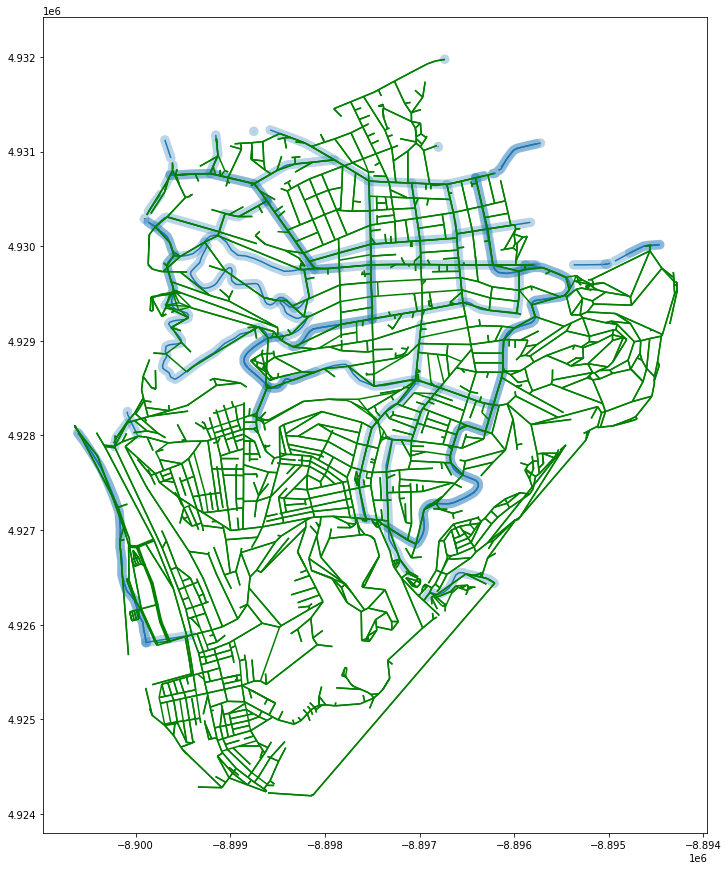

In [21]:
gdf_bikeway['line_buffer_geom'] = gdf_bikeway['geometry'].buffer(distance = 2)  # 2 meter radius
gdf_bikeway.set_geometry('geometry', inplace=True)
fig, ax = fig, ax = plt.subplots(figsize=(15,15))
gdf_bikeway.plot(ax=ax)
# some buffer testing (exagerrate the buffer for visualization)
gdf_bikeway['geometry'].buffer(50).plot(ax=ax, alpha=0.3)
#gdf_bike_nodes.plot(ax=ax, color='red', markersize=10, zorder=3)
gdf_bike_edges.plot(ax=ax, color='green', markersize=10)

In [22]:
gdf_bikeway.set_geometry('line_buffer_geom', inplace=True)
gdf_bike_join = gdf_bike_nodes.sjoin(gdf_bikeway, how='inner', predicate='intersects')
gdf_bike_join.head(5)

,nodeID,y,x,street_count,highway,geometry_left,index_right,geometry_right,bikeway_type
38,104365108,40.426674,-79.938608,3,NaN,POINT (-8898725.148 4928140.489),171,"LINESTRING (-8898759.534 4928073.129, -8898733...",On Street Bike Route
578,105142790,40.432836,-79.936566,4,traffic_signals,POINT (-8898497.789 4929041.631),171,"LINESTRING (-8898759.534 4928073.129, -8898733...",On Street Bike Route
703,105797418,40.427050,-79.938568,4,traffic_signals,POINT (-8898720.729 4928195.503),171,"LINESTRING (-8898759.534 4928073.129, -8898733...",On Street Bike Route
893,302981356,40.434273,-79.933685,3,NaN,POINT (-8898177.111 4929251.792),171,"LINESTRING (-8898759.534 4928073.129, -8898733...",On Street Bike Route
894,302981485,40.432904,-79.935986,3,NaN,POINT (-8898433.302 4929051.620),171,"LINESTRING (-8898759.534 4928073.129, -8898733...",On Street Bike Route


In [23]:
gdf_bike_join.shape

(317, 9)

geopandas.geodataframe.GeoDataFrame

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

<AxesSubplot:>

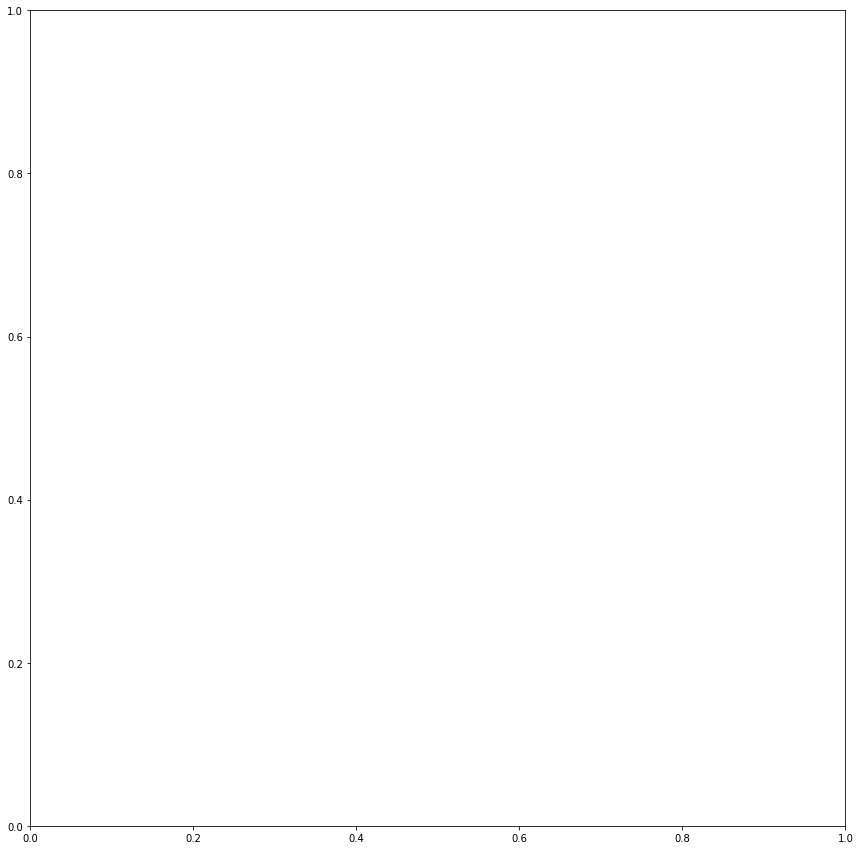

In [24]:
# Some testing to see if this worked... looks correct
temp = gdf_bike_join.loc[gdf_bike_join.index_right == 41]
temp = gpd.GeoDataFrame(data=temp)
type(temp)
fig, ax = plt.subplots(figsize=(15,15))
temp.set_geometry('geometry_left', inplace=True)
temp.plot(ax=ax, color= 'red')
temp.set_geometry('geometry_right', inplace=True)
temp.plot(ax=ax, color='blue', alpha=0.3)

In [25]:
# Now join gdf_bike_join to gdf_bike_edges
gdf_bike_join.sort_values(by='nodeID', inplace=True)
gdf_bike_join.loc[gdf_bike_join.nodeID == 104538933]
gdf_bike_edges_bikeway = pd.merge(gdf_bike_edges, gdf_bike_join, how='left', left_on = 'source', right_on = 'nodeID')
#gdf_bike_edges_bikeway.head()
cols_keep = ['source','target', 'geometry', 'index_right', 'bikeway_type']
gdf_bike_edges_bikeway = gdf_bike_edges_bikeway[cols_keep].rename(columns={'index_right':'bikeway_idx_source'})
temp2 = pd.merge(gdf_bike_edges_bikeway, gdf_bike_join, how='left', left_on = 'target', right_on = 'nodeID',
                 suffixes=['_source', '_target'])
cols_keep = ['source','target', 'geometry', 'bikeway_idx_source', 'bikeway_type_source', 'index_right', 'bikeway_type_target']
temp2 = temp2[cols_keep].rename(columns={'index_right':'bikeway_idx_target'})
temp2.head()

,nodeID,y,x,street_count,highway,geometry_left,index_right,geometry_right,bikeway_type
125,104538933,40.445631,-79.931202,3,traffic_signals,POINT (-8897900.716 4930913.102),201,"LINESTRING (-8898746.041 4930657.185, -8898418...",On Street Bike Route
125,104538933,40.445631,-79.931202,3,traffic_signals,POINT (-8897900.716 4930913.102),87,"MULTILINESTRING ((-8898578.620 4931229.186, -8...",On Street Bike Route


,source,target,geometry,bikeway_idx_source,bikeway_type_source,bikeway_idx_target,bikeway_type_target
0,104194342,104485848,"LINESTRING (-8897716.316 4926340.324, -8897780...",NaN,NaN,NaN,NaN
1,104194342,1768974300,"LINESTRING (-8897716.316 4926340.324, -8897580...",NaN,NaN,NaN,NaN
2,104194342,104194402,"LINESTRING (-8897716.316 4926340.324, -8898043...",NaN,NaN,NaN,NaN
3,104194402,104194450,"LINESTRING (-8898043.016 4926714.742, -8898087...",NaN,NaN,NaN,NaN
4,104194402,104194342,"LINESTRING (-8898043.016 4926714.742, -8897716...",NaN,NaN,NaN,NaN


In [26]:
approx_bike_edges = temp2.loc[temp2.bikeway_idx_source == temp2.bikeway_idx_target]
approx_bike_edges.head(5)

,source,target,geometry,bikeway_idx_source,bikeway_type_source,bikeway_idx_target,bikeway_type_target
111,104365108,8703692468,"LINESTRING (-8898725.148 4928140.489, -8898722...",171.0,On Street Bike Route,171.0,On Street Bike Route
283,104513444,3428121851,"LINESTRING (-8896121.352 4928667.798, -8896120...",94.0,On Street Bike Route,94.0,On Street Bike Route
286,104513444,3428121851,"LINESTRING (-8896121.352 4928667.798, -8896120...",21.0,Bike Lanes,21.0,Bike Lanes
304,104524752,104583203,"LINESTRING (-8898506.172 4930800.821, -8898568...",201.0,On Street Bike Route,201.0,On Street Bike Route
306,104524752,104583238,"LINESTRING (-8898506.172 4930800.821, -8898312...",201.0,On Street Bike Route,201.0,On Street Bike Route


In [27]:
approx_bike_edges.head()

,source,target,geometry,bikeway_idx_source,bikeway_type_source,bikeway_idx_target,bikeway_type_target
111,104365108,8703692468,"LINESTRING (-8898725.148 4928140.489, -8898722...",171.0,On Street Bike Route,171.0,On Street Bike Route
283,104513444,3428121851,"LINESTRING (-8896121.352 4928667.798, -8896120...",94.0,On Street Bike Route,94.0,On Street Bike Route
286,104513444,3428121851,"LINESTRING (-8896121.352 4928667.798, -8896120...",21.0,Bike Lanes,21.0,Bike Lanes
304,104524752,104583203,"LINESTRING (-8898506.172 4930800.821, -8898568...",201.0,On Street Bike Route,201.0,On Street Bike Route
306,104524752,104583238,"LINESTRING (-8898506.172 4930800.821, -8898312...",201.0,On Street Bike Route,201.0,On Street Bike Route


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

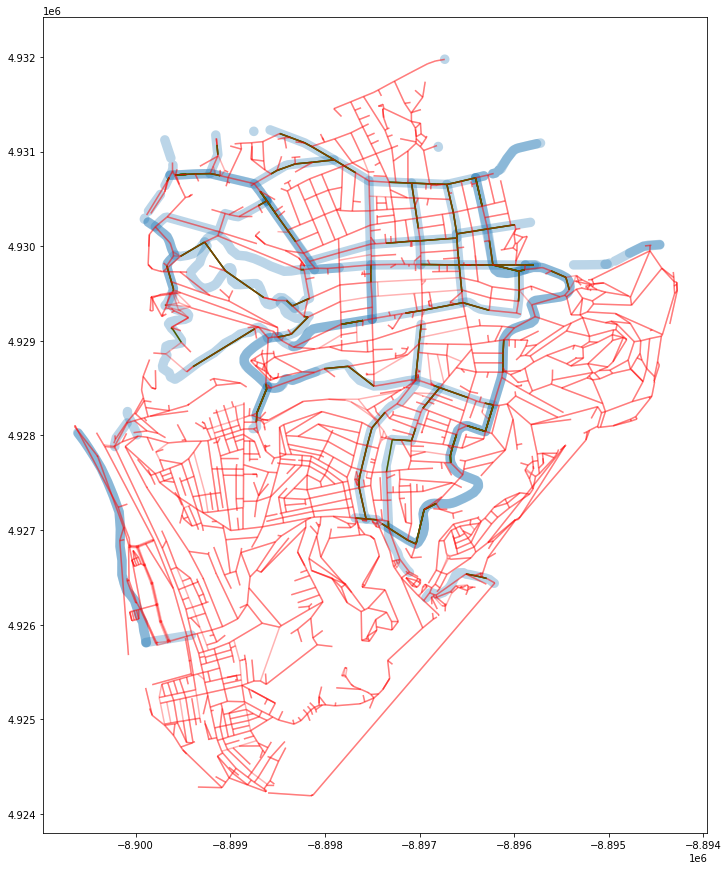

In [28]:
gdf_bikeway['line_buffer_geom'] = gdf_bikeway['geometry'].buffer(distance = 2)  # 2 meter radius
gdf_bikeway.set_geometry('geometry', inplace=True)
fig, ax = fig, ax = plt.subplots(figsize=(15,15))
#gdf_bikeway.plot(ax=ax)
# some buffer testing (exagerrate the buffer for visualization)
gdf_bikeway['geometry'].buffer(50).plot(ax=ax, alpha=0.3)
#gdf_bike_nodes.plot(ax=ax, color='red', markersize=2, zorder=3)
approx_bike_edges.plot(ax=ax, color='green')
gdf_bike_edges.plot(ax=ax, color='red', alpha=0.3)

In [29]:
# look for duplicates by [source, target] in approx edges
approx_bike_edges.loc[:,'temp'] = approx_bike_edges['source'].astype('str') + '_' + approx_bike_edges['target'].astype('str')
approx_bike_edges['temp'].unique().shape
approx_bike_edges.shape
bikeway_map = {'Protected Bike Lane':1, 'Bike Lanes':2, 'On Street Bike Route':3}
approx_bike_edges.loc[:,'type_int'] = approx_bike_edges['bikeway_type_source'].map(bikeway_map)
approx_bike_edges.sort_values(by = ['type_int'], ascending=True, inplace=True)
approx_bike_edges.drop_duplicates(subset=['source','target'], keep='first', inplace=True)
cols_keep = ['source', 'target', 'geometry', 'bikeway_idx_source','bikeway_type_source', 'bikeway_idx_target', 'bikeway_type_target']
approx_bike_edges = approx_bike_edges[cols_keep]
approx_bike_edges.shape

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(395,)

(454, 8)

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-29-8f5b66f11ed3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approx_bike_edges.sort_values(by = ['type_int'], ascending=True, inplace=True)
<ipython-input-29-8f5b66f11ed3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

(395, 7)

In [30]:
# save as csv
new_dir = cwd.replace('Code', 'Data/')
os.chdir(new_dir)
approx_bike_edges.to_csv('bikeway_edges.csv', index=False)